In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.pipeline import Pipeline, FeatureUnion


In [2]:
df = pd.read_csv(r"C:\Users\DHONI HANIF\OneDrive\Documents\AI Collection and Loss Reverse Forecast\data_preparation\EDA\Univariate_bivariate_multivariate\Univariate_Analysis\new_kolektor.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1000 non-null   int64  
 1   time_to_collect        1000 non-null   int64  
 2   avg_bill_methods       1000 non-null   object 
 3   debtor_volume_handled  1000 non-null   int64  
 4   bill_amount_collected  1000 non-null   int64  
 5   total_actual           1000 non-null   int64  
 6   total_cost             1000 non-null   int64  
 7   success_rate           1000 non-null   float64
dtypes: float64(1), int64(6), object(1)
memory usage: 62.6+ KB


In [3]:
for i in df.columns:
    if df[i].dtype == "object":
        df[i] = df[i].astype("category")

df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [4]:
df.head()

,time_to_collect,avg_bill_methods,debtor_volume_handled,bill_amount_collected,total_actual,total_cost,success_rate
0,0,sms or WA,7,14400000,35700000,277706,40.0
1,11,panggilan,35,79000000,160500000,22382611,49.0
2,4,sms or WA,6,7100000,26700000,205389,27.0
3,29,datang ke tempat,63,782000000,1395000000,482942548,56.0
4,22,datang ke tempat,35,346000000,485500000,151035603,71.0


In [5]:
bill_methods = {"sms or WA": 0, "surat panggilan": 1, "panggilan": 2, "datang ke tempat": 3}
columns = {"avg_bill_methods": bill_methods}
for i in df.columns:
    if df[i].dtype == "category" or df[i].dtype == "object":
        df[i] = [columns[i][j] for j in df[i]]

y = df["total_cost"]
df.drop("total_cost", axis=1, inplace=True)             
scaler = RobustScaler().fit(df[[i for i in df.columns if i not in columns]])
df2 = pd.DataFrame(scaler.transform(df[[i for i in df.columns if i not in columns]]), columns=df[[i for i in df.columns if i not in columns]].columns)
for i in columns:
    df2[i] = df[i]
df2.head(5)

,time_to_collect,debtor_volume_handled,bill_amount_collected,total_actual,success_rate,avg_bill_methods
0,-1.000000,-1.347826,-0.459398,-0.520698,-0.363636,0
1,-0.266667,-0.130435,-0.282327,-0.344973,-0.159091,2
2,-0.733333,-1.391304,-0.479408,-0.533371,-0.659091,0
3,0.933333,1.086957,1.644624,1.393270,0.000000,3
4,0.466667,-0.130435,0.449531,0.112644,0.340909,3


In [6]:
X = df2
pca = PCA()
pca.fit(X)

PCA()

In [7]:
# Tentukan jumlah principal component yang optimal
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

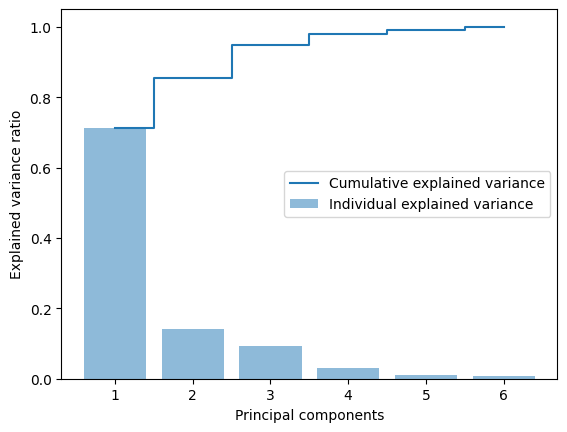

In [8]:
# Tampilkan visualisasi dari hasil PCA dengan warna yang berbeda untuk masing-masing principal component
plt.bar(range(1, len(cum_var_exp)+1), var_exp, alpha=0.5, align="center", label="Individual explained variance")
plt.step(range(1, len(cum_var_exp)+1), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.legend(loc="best")
plt.show()

In [9]:
# Mengambil komponen utama yang paling penting (misalnya, dua komponen pertama)
features = np.array(X.columns)
n_top_components = 5
top_component_indices = np.argsort(np.abs(pca.components_))[:, -n_top_components:]

# Mengambil nama fitur-fitur yang paling penting
top_feature_names = [features[i] for i in top_component_indices]

print("Fitur-fitur yang paling penting:")
for i, feature_set in enumerate(top_feature_names):
    print(f"Komponen Utama {i + 1}: {', '.join(feature_set)}")

Fitur-fitur yang paling penting:
Komponen Utama 1: time_to_collect, total_actual, debtor_volume_handled, bill_amount_collected, avg_bill_methods
Komponen Utama 2: time_to_collect, total_actual, avg_bill_methods, success_rate, bill_amount_collected
Komponen Utama 3: bill_amount_collected, time_to_collect, avg_bill_methods, total_actual, success_rate
Komponen Utama 4: success_rate, bill_amount_collected, time_to_collect, avg_bill_methods, debtor_volume_handled
Komponen Utama 5: avg_bill_methods, debtor_volume_handled, success_rate, bill_amount_collected, total_actual
Komponen Utama 6: total_actual, success_rate, debtor_volume_handled, avg_bill_methods, time_to_collect


In [10]:
# Temukan jumlah komponen utama yang menjelaskan sebagian besar varians
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance_ratio >= 0.98) + 1
print(f'Jumlah komponen utama yang menjelaskan 98% varians: {n_components}')

Jumlah komponen utama yang menjelaskan 98% varians: 4


In [11]:
features = np.array(X.columns)
select = SelectKBest(score_func=f_regression, k=5)
z = select.fit_transform(X, y) 

In [12]:
filterr = select.get_support()
features[filterr]

array(['time_to_collect', 'debtor_volume_handled',
       'bill_amount_collected', 'total_actual', 'avg_bill_methods'],
      dtype=object)

In [13]:
num_features_to_select = 5
# Buat instance PCA
pca = PCA(n_components=num_features_to_select)

# Buat instance SelectKBest dengan uji statistik f_classif (sesuaikan dengan tipe data dan masalah Anda)
select_k_best = SelectKBest(score_func=f_classif, k=num_features_to_select)

# Gabungkan keduanya dalam pipeline
combined_features = FeatureUnion([("pca", pca), ("select_k_best", select_k_best)])

# Buat model akhir (misalnya, classifier) setelah pemilihan fitur
# Di sini, kita tidak menambahkan classifier karena fokus pada pemilihan fitur
# Anda dapat menambahkan classifier sesuai kebutuhan

# Buat pipeline yang menggabungkan seleksi fitur dan model akhir
pipeline = Pipeline([("features", combined_features)])

X_new = pipeline.fit_transform(X, y)



c:\Users\DHONI HANIF\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


In [14]:
# Setelah Anda memiliki pipeline yang sudah di-fit dan transform (seperti di atas)
# Dapatkan indeks fitur-fitur terbaik dari objek SelectKBest
feature_indices = select_k_best.get_support(indices=True)

# Ambil nama fitur dari dataset asli (misalnya, iris dataset)
selected_feature_names = [features[i] for i in feature_indices]

# Cetak nama-nama fitur yang dipilih
print("Fitur yang dipilih:")
for i, j in enumerate(selected_feature_names):
    print(i+1, j)

Fitur yang dipilih:
1 debtor_volume_handled
2 bill_amount_collected
3 total_actual
4 success_rate
5 avg_bill_methods


In [15]:
bill_methods = {j: i for i, j in bill_methods.items()}
columns = {"avg_bill_methods": bill_methods}
for i in columns:
    df[i] = [columns[i][j] for j in df[i]]

df2[[i for i in df.columns if i not in columns]] = scaler.inverse_transform(df2[[i for i in df.columns if i not in columns]])             

df2.head(5)

,time_to_collect,debtor_volume_handled,bill_amount_collected,total_actual,success_rate,avg_bill_methods
0,0.0,7.0,14400000.0,3.570000e+07,40.0,0
1,11.0,35.0,79000000.0,1.605000e+08,49.0,2
2,4.0,6.0,7100000.0,2.670000e+07,27.0,0
3,29.0,63.0,782000000.0,1.395000e+09,56.0,3
4,22.0,35.0,346000000.0,4.855000e+08,71.0,3


In [16]:
df_new = df2[selected_feature_names]
df_new["total_cost"] = y
df_new.head()

,debtor_volume_handled,bill_amount_collected,total_actual,success_rate,avg_bill_methods,total_cost
0,7.0,14400000.0,3.570000e+07,40.0,0,277706
1,35.0,79000000.0,1.605000e+08,49.0,2,22382611
2,6.0,7100000.0,2.670000e+07,27.0,0,205389
3,63.0,782000000.0,1.395000e+09,56.0,3,482942548
4,35.0,346000000.0,4.855000e+08,71.0,3,151035603


In [17]:
df_new.to_csv("./data/new_kolektor_data.csv")